In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.ndimage import gaussian_filter
from astropy.modeling.models import Sersic1D,Sersic2D
from scipy.optimize import curve_fit

#import galaxy_tools as gal
from mockobservation_tools.general_tools import measure_surfbright
from mockobservation_tools.sersic_tools import fit_sersic, sersic2D_forfit

pd.set_option('display.max_columns', None)
%matplotlib inline

palettable colormaps are not installed
don't have phil's colormaps


##### Note: This notebook was created to run on my local based on the paths used

### Sersic2D Function

Overview of the astropy Sersic2D model

amplitude : Surface brightness at r_eff \
r_eff     : Effective (half-light) radius \
n         : Sersic Index \
x_0, y_0: Center coordinates \
ellip     : Ellipticity \
theta     : Rotation angle in radians, counterclockwise from the positive x-axis

#### Code taken from astropy that executes the Sersic2D model
def evaluate(cls, x, y, amplitude, r_eff, n, x_0, y_0, ellip, theta):
        """Two dimensional Sersic profile function."""

        if cls._gammaincinv is None:
            try:
                from scipy.special import gammaincinv
                cls._gammaincinv = gammaincinv
            except ValueError:
                raise ImportError('Sersic2D model requires scipy.')

        bn = cls._gammaincinv(2. * n, 0.5)
        a, b = r_eff, (1 - ellip) * r_eff
        cos_theta, sin_theta = np.cos(theta), np.sin(theta)
        x_maj = (x - x_0) * cos_theta + (y - y_0) * sin_theta
        x_min = -(x - x_0) * sin_theta + (y - y_0) * cos_theta
        z = np.sqrt((x_maj / a) ** 2 + (x_min / b) ** 2)

        return amplitude * np.exp(-bn * (z ** (1 / n) - 1))



#### Overview of the code
The major axis (a) is used as r_eff. \
The minor axis (b) is scaled based on the ellipticity (e) of the fit. \
The axis is rotated by theta counterclockwise from the positive x-axis to the major axis of the fit. \
The new x-axis is aligned with the major axis of the fit (x_maj) \
The new y-axis is aligned with the minor axis of the fit (x_min) \
The rotation is a typical axis roation: x' = x cos$\theta$ + y sin$\theta$, y' = -x cos$\theta$ + y cos$\theta$

The equation used in Sersic2D: 
$$ A e^{-bn  [z^{(1 / n)} - 1)]}$$

The equation used in Sersic1D: 
$$ A e^{-bn  [(r / Re)^{(1 / n)} - 1)]}$$

Although both use bn, in Sersic2D they use the Γ(2𝑛)=2𝛾(2𝑛,𝑏𝑛), \
The general Sersic bn I have used uses the approximation: \
bn = 2n - 0.327 approximation for 0.5 < n < 10

$z = \sqrt{(x_{maj} / a)^2 + (x_{min} / b)^2}$ which is the 2D equivelent to r / Re


###### Note: When n = 1 that is equivalent to exponential decay

### Fitting 2D Sersic

To use Sersic2D you need to input an array for x and y values inwhich to execuate the function

The input x,y values can be a 1D array \
ex: \
x = [-2,-1,0,1,2], y = [0,0,0,0,0]

Or a 2D mesh of points to evalute the function \
ex: \
x, y = np.linspace(-FOV, FOV, pixel), np.linspace(-FOV, FOV, pixel) \
X, Y = np.meshgrid(x, y)

Make sure the values are in physical coordinates, not pixel values

#### Fitting using curve_fit
To fit the Sersic2D, Use scipy curve_fit

The Sersic2D function has an x and y input, but the curve_fit needs one input array, so I have adjust the function as sersic_2D_forfit to enable 1 input array with the other same input parameters.

The grid you create is eqivalent to that of the coordinates of the image you will be fitting. Note that the FOV goes to the edge of the image, but we want our array to indicate the coordinates of the center of the pixels. If the pixel size is 2 * FOV / number of pixels, then the length from the edge of a pixel to the center is half of that, or FOV / number of pixels. So the array should go from FOV_pixel_center = FOV - FOV / number of pixels. curve_fit does not like the input array to be the meshgrid, so flatted the x and y grids and stack them into a 2D arrary.


x, y = np.linspace(-FOV_pixel_center, FOV_pixel_center, pixel), np.linspace(-FOV_pixel_center, FOV_pixel_center, pixel) \
X, Y = np.meshgrid(x, y) \
mesh = np.vstack((X.ravel(), Y.ravel())) 


In [6]:
path = '/Users/courtneyklein/Research/DwarfGalaxy_MassRadius/data/mock_image_files_round2/'

band_image = np.load(path + 'm11i_res7100_ugrband_xy_FOV20_p1000.npy')[1]
mock_image = np.load(path + 'm11i_res7100_mockimg_xy_FOV20_p1000.npy')

pixel = 1000
FOV = 20

---------------------------------------------
sersic
Effective Intensity: 1.38e+07 Lsun
Effective Radius:    2.19 kpc
Sersic Index:        0.67
---------------------------------------------
sersic1D
Effective Intensity: 1.37e+07 Lsun
Effective Radius:    2.21 kpc
Sersic Index:        0.67


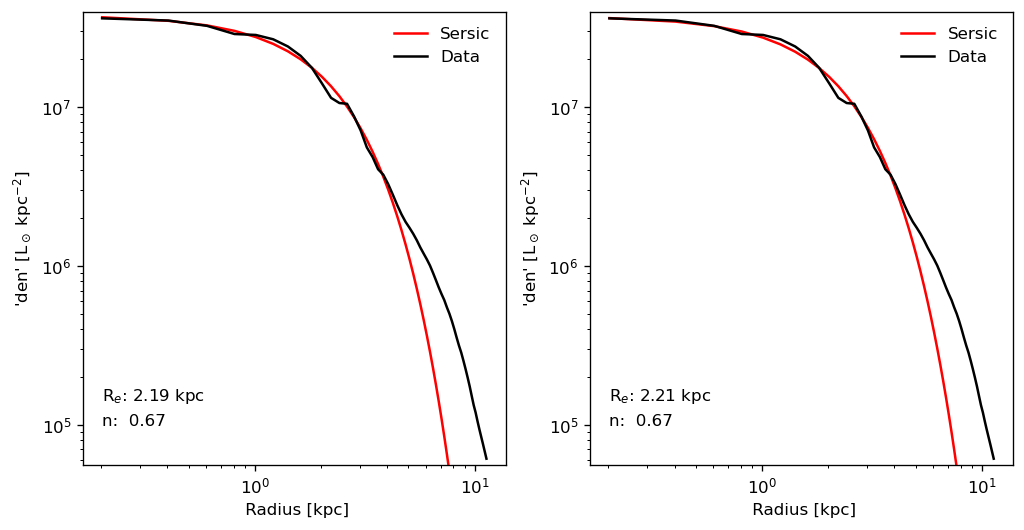

In [7]:
fig, axs = plt.subplots(1,2,figsize=(10, 5))

r,sb = measure_surfbright(band_image, FOV)
params, std = fit_sersic(r,sb,FOV=FOV,sersic_type='sersic',ax_sersic=axs[0])
print('---------------------------------------------')
print('sersic')

print(f'Effective Intensity: {params[0]:.2e} Lsun')
print(f'Effective Radius:    {params[1]:.2f} kpc')
print(f'Sersic Index:        {params[2]:.2f}')

params, std = fit_sersic(r,sb,FOV=FOV,sersic_type='sersic1D',ax_sersic=axs[1])

print('---------------------------------------------')
print('sersic1D')

print(f'Effective Intensity: {params[0]:.2e} Lsun')
print(f'Effective Radius:    {params[1]:.2f} kpc')
print(f'Sersic Index:        {params[2]:.2f}')

In [8]:
fit_sersic?

### Code used in fit_sersic

#Note that fit_sersic is commented and it is encourge that you review the different variables. 

The default value for sersic_type is 'sersic'\
'sersic': uses the function I created, which uses a simplification for the bn value. For more info (sersic_tools.sersic?)\
'sersic1D': fits the data using astropy.modeling.models.Sersic1D\
'sersic2D': fits the data using astropy.modeling.models.Sersic2D

    
The code below is used in the fit_sersic but is written out here to explore what different pieces are doing


sersic2D_forfit is used to create the Sersic2D function in a form that can be used by curve_fit


In [10]:
r,sb = measure_surfbright(band_image, FOV)
params, std = fit_sersic(r,sb,FOV=FOV,sersic_type='sersic')

mid_pixel_FOV = FOV - FOV / pixel
x, y = np.linspace(-mid_pixel_FOV, mid_pixel_FOV, pixel), np.linspace(-mid_pixel_FOV, mid_pixel_FOV, pixel)
X, Y = np.meshgrid(x, y)
mesh1D = np.vstack((X.ravel(), Y.ravel()))

# Use 1D fit as guess parameters
guess_prms = [params[0],params[1],params[2],0,0,0,0]

# Add bounds 0:amp, 1:r_eff, 2:n, 3:x_0, 4:y_0, 5:ellip, 6:theta

print('---------------------------------------------')

print('1D Parameters:')
print(f'Effective Intensity: {guess_prms[0]:.2e} Lsun')
print(f'Half light radius:   {guess_prms[1]:.2f} kpc')
print(f'Sersic Index:        {guess_prms[2]:.2f}')

popt, pcov = curve_fit(sersic2D_forfit, mesh1D, band_image.ravel(), guess_prms,
                       bounds=((0, 0, 0, -np.inf, -np.inf, 0, -np.inf),
                               (np.inf, np.inf, np.inf, np.inf, np.inf, 1, np.inf)))

popt_sim = popt

# ave_r = (a + b)/2 = (a + a(1-e))/2 = a(2-e)/2

print('---------------------------------------------')

print('2D Parameters:')
print(f'Effective Intensity: {popt[0]:.2e} Lsun')
print(f'Major Axis Radius:   {popt[1]:.2f} kpc')
print(f'Average Axis Radius: {popt[1] * (2 - popt[5]) / 2:.2f} kpc')
print(f'Sersic Index:        {popt[2]:.2f}')
print(f'Ellipticity:         {popt[5]:.2f}')
print(f'Theta:               {popt[6]%(np.pi):.2f}, {popt[6]%(np.pi) * 180 / np.pi:.2f} degrees')

band_image_smoothed = gaussian_filter(band_image, sigma = 20)

popt, pcov = curve_fit(sersic2D_forfit, mesh1D, band_image_smoothed.ravel(), guess_prms,
                       bounds=((0, 0, 0, -np.inf, -np.inf, 0, -np.inf),
                               (np.inf, np.inf, np.inf, np.inf, np.inf, 1, np.inf)))

popt_smoothed = popt

print('---------------------------------------------')

print('2D Parameters Smoothed:')
print(f'Effective Intensity: {popt[0]:.2e} Lsun')
print(f'Major Axis Radius:   {popt[1]:.2f} kpc')
print(f'Average Axis Radius: {popt[1] * (2 - popt[5]) / 2:.2f} kpc')
print(f'Sersic Index:        {popt[2]:.2f}')
print(f'Ellipticity:         {popt[5]:.2f}')
print(f'Theta:               {popt[6]%(np.pi):.2f}, {popt[6]%(np.pi) * 180 / np.pi:.2f} degrees')




---------------------------------------------
1D Parameters:
Effective Intensity: 1.38e+07 Lsun
Half light radius:   2.19 kpc
Sersic Index:        0.67
---------------------------------------------
2D Parameters:
Effective Intensity: 1.60e+07 Lsun
Major Axis Radius:   2.95 kpc
Average Axis Radius: 2.16 kpc
Sersic Index:        0.59
Ellipticity:         0.54
Theta:               0.78, 44.80 degrees
---------------------------------------------
2D Parameters Smoothed:
Effective Intensity: 1.10e+07 Lsun
Major Axis Radius:   3.37 kpc
Average Axis Radius: 2.60 kpc
Sersic Index:        0.67
Ellipticity:         0.46
Theta:               0.73, 42.10 degrees


#### Effects of adding the bounds of the curve_fit

When there is no constraints, ellipticity can be negative which just means that the minor axis is larger than the major axis. This also means that the effective radius would be for the minor axis. But the looking at the ratio between the larger and smaller axis lenghts, they are the same ratio. 

When constraining the Intensity, Effective Radius, and Ellipticity to greater than zero, then it ensures the major axis is the effectice radius. 

However, everytime I add a contrained the theta it significantly changes the fit ellipticity and theta. When there is no contraint, it produces different values however it is the same equivelent angle. The angle should be between 0 and $\pi$. Instead of contraining the angle, I can just take the modulus of the angle with respect to $\pi$. 



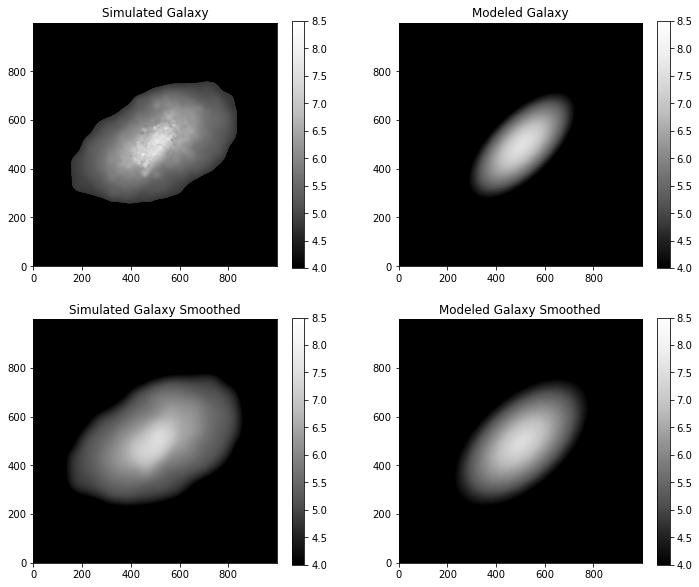

In [11]:
model = Sersic2D(*popt_sim)
model_image = model(X,Y)
log_model_image = np.log10(model_image)

model_smoothed = Sersic2D(*popt_smoothed)
model_image_smoothed = model_smoothed(X,Y)
log_model_image_smoothed = np.log10(model_image_smoothed)

fig, axs = plt.subplots(2,2,figsize=(12, 10))

simim = axs[0,0].imshow( np.log10(band_image + 1), origin='lower', vmin=4, vmax=8.5 , cmap='Greys_r')
fig.colorbar(simim, ax=axs[0,0])
axs[0,0].set_title('Simulated Galaxy')

fitim = axs[0,1].imshow(log_model_image, origin='lower', interpolation='nearest', vmin=4, vmax=8.5, cmap='Greys_r')
fig.colorbar(fitim, ax=axs[0,1])
axs[0,1].set_title('Modeled Galaxy')

simim = axs[1,0].imshow( np.log10(band_image_smoothed + 1), origin='lower', vmin=4, vmax=8.5, cmap='Greys_r' )
fig.colorbar(simim, ax=axs[1,0])
axs[1,0].set_title('Simulated Galaxy Smoothed')

fitim = axs[1,1].imshow(log_model_image_smoothed, origin='lower', interpolation='nearest', vmin=4, vmax=8.5, cmap='Greys_r')
fig.colorbar(fitim, ax=axs[1,1])
axs[1,1].set_title('Modeled Galaxy Smoothed')

#fig.savefig('plots/sersic2d_model.png')
plt.show()

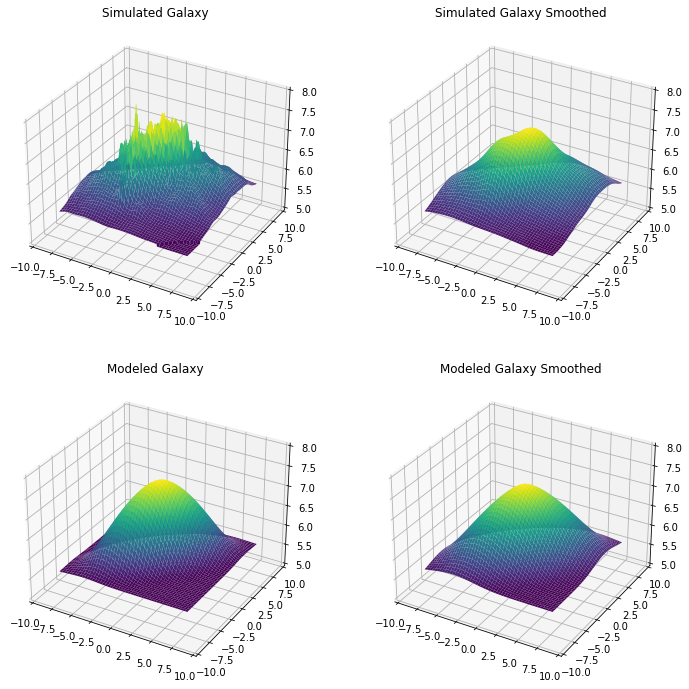

In [12]:
fig = plt.figure(figsize = (12,12))

i = 300
X_lim = X[i:-i,i:-i]
Y_lim = Y[i:-i,i:-i]

band_image_lim = band_image[i:-i,i:-i]
band_image_smoothed_lim = band_image_smoothed[i:-i,i:-i]

model_image_lim = model_image[i:-i,i:-i]
model_image_smoothed_lim = model_image_smoothed[i:-i,i:-i]

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.plot_surface(X_lim, Y_lim, np.log10(band_image_lim + 4e5), cmap='viridis')
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(5,8)
ax.set_title('Simulated Galaxy')

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.plot_surface(X_lim, Y_lim, np.log10(band_image_smoothed_lim + 4e5), cmap='viridis')
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(5,8)
ax.set_title('Simulated Galaxy Smoothed')

ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.plot_surface(X_lim, Y_lim, np.log10(model_image_lim + 4e5), cmap='viridis')
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(5,8)
ax.set_title('Modeled Galaxy')

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.plot_surface(X_lim, Y_lim, np.log10(model_image_smoothed_lim + 4e5), cmap='viridis')
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(5,8)
ax.set_title('Modeled Galaxy Smoothed')

plt.show()


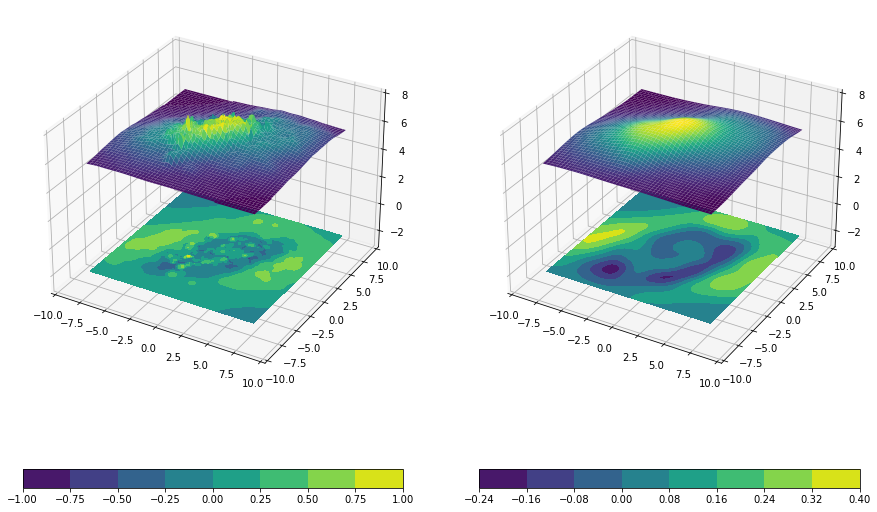

<Figure size 432x288 with 0 Axes>

In [13]:
fig = plt.figure(figsize = (15, 10))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X_lim, Y_lim, np.log10(band_image_lim + 4e5), cmap='viridis')
cset = ax.contourf(X_lim, Y_lim, np.log10(band_image_lim + 4e5) - np.log10(model_image_lim + 4e5), zdir='z', offset=-2, cmap='viridis')
fig.colorbar(cset, location='bottom')

ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(-3,8)
#ax.set_title('Simulated Galaxy')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X_lim, Y_lim, np.log10(band_image_smoothed_lim + 4e5), cmap='viridis')
cset = ax.contourf(X_lim, Y_lim, np.log10(band_image_smoothed_lim + 4e5) - np.log10(model_image_smoothed_lim + 4e5), zdir='z', offset=-2, cmap='viridis')
fig.colorbar(cset, location='bottom')

ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(-3,8)
#ax.set_title('Simulated Galaxy Smoothed')

plt.show()
plt.tight_layout()

#fig.savefig('plots/simsmooth_gal_resid.png')

